## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from scipy import stats
%matplotlib inline

## Load Dataset

In [3]:
file_path = r"C:\Users\fabia\OneDrive - National University of Singapore\Documents\SDS Insurance Price Predictor\insurance.csv"
# Load data into dataframe
df = pd.read_csv(file_path)

---
## Preliminary Data Exploration

In [4]:
# Check columns and rows
print(f"Total number of rows: {len(df)}")
print(f"Total number of columns: {len(df.columns)}")
print("\n" + "="*50 + "\n")

# Summarise statistics for all columns
print("Summary Statistics:")
print(df.describe(include='all'))

Total number of rows: 1338
Total number of columns: 7


Summary Statistics:
                age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000000    NaN        NaN   

             charges  
count    1338.000000  
u

**Summary**
* 1338 records imported successfully.
* Nullity check confirms all columns are fully populated (1338 non-null count). No missing values
* Continuous variables (age, bmi, children, charges) fall within expected, logical ranges.
* Data appears valid and free from significant entry errors or anomalies.

The dataset is clean, complete, and well-structured.

---
## Exploratory Data Analysis
An initial exploratory data analysis (EDA) will be performed on the US health insurance dataset. This involves examining the distributions of the predictor variables and the target variable ('charges') to derive preliminary insights, assess sample representativeness of the US population, and evaluate potential sampling bias.

### Distribution of Age

In [ ]:
# plot histogram of age
fig = px.histogram(df, 
                   x='age', 
                   nbins=47,    # max age - min age. 1 bin for each age
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

**Analysis**  
The age distribution is largely uniform (23-29 observations per age group), with significant spikes at ages 18 (n=69) and 19 (n=68). This is likely due to new adults purchasing their first independent insurance.  
The overall distribution aligns with US demographics.

### Distribution of Sex

In [15]:
# Group by BOTH 'sex' and 'smoker' to get counts
sex_smoker_counts = df.groupby(['sex', 'smoker']).size().reset_index(name='count')

# bar plot of sex counts, separated by smoker status
fig = px.bar(sex_smoker_counts,
             x='sex',
             y='count',
             color='smoker',  # splits bars by smoker status
             title='Distribution of Sex by Smoker Status')
fig.update_layout(width=500)
fig.show()

# % of smokers by sex
female_smokers_percent = 115/662 * 100
male_smokers_percent = 159/676 * 100
print(f"Percentage of female smokers: {female_smokers_percent:.2f}%")
print(f"Percentage of male smokers: {male_smokers_percent:.2f}%")

Percentage of female smokers: 17.37%
Percentage of male smokers: 23.52%


**Analysis**  
The sample is gender-balanced (676 males, 662 females), reflecting US demographics. Higher percentage of smokers in males (23.5% vs 17.4%).

### Distribution of BMI

In [7]:
# plot histogram of bmi, with an addition of box plot 
fig = px.histogram(df, x='bmi', marginal='box', title='Distribution of BMI')
fig.update_layout(bargap=0.1)
fig.update_layout(width=800)
fig.show()

# count outliers in bmi > 46.75
outliers = df[df['bmi'] > 46.75]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 9


**Analysis**  
BMI is approximately normally distributed, consistent with population-level anthropometric data. Nine outliers (BMI > 46.75) identified via IQR method, but are retained as they represent legitimate high-risk cases relevant for charges prediction.

### Distribution of Region

In [7]:
# create dataframe with 'region' categories and their counts
region_counts = df['region'].value_counts().reset_index()
region_counts.columns = ['region', 'count']

# bar plot
fig = px.bar(region_counts, x='region', y='count', title='Distribution of Region')
fig.update_layout(width=600)
fig.show()

**Analysis**  
The sample is geographically balanced.

### Distribution of Children

In [8]:
# 0 to 5 children
fig = px.histogram(df, x='children', title='Distribution of Children')
fig.update_layout(bargap=0.1)
fig.update_layout(width=600)
fig.show()

**Analysis**  
The distribution of `children` is right-skewed, with most beneficiaries having 0-3 children. Sample sizes are adequate for these groups (574, 324, 240, 157 respectively), but notably small for families with 4-5 children (25 and 18 observations). Limited observations for larger families may yield unreliable coefficient estimates. We will examine the relationship between children and charges to assess whether this sparse data poses a practical concern. If the relationship is weak, the small sample size becomes less problematic.

In [9]:
# scatter plot of children vs charges with plotted trendline
fig = px.scatter(df, x='children', y='charges', title='Children vs Charges', trendline='ols')
fig.update_layout(width=700)
fig.show()

# pearson correlation between children and charges
correlation = df['children'].corr(df['charges'])
print(f"Pearson correlation between children and charges: {correlation:.3f}")

Pearson correlation between children and charges: 0.068


**Analysis**  
`children` is a weak predictor of `charges`, as shown by a low Pearson correlation (r = 0.068) and a flat regression line. The charge distributions are similar for all family sizes, so the lack of data for larger families is not a major issue.

### Distribution of Smokers

In [10]:
# create dataframe with 'smoker' categories and their counts
smoker_counts = df['smoker'].value_counts().reset_index()
smoker_counts.columns = ['smoker', 'count']

# bar plot
fig = px.bar(smoker_counts, x='smoker', y='count', title='Distribution of Smoker')
fig.update_traces(width=0.7)
fig.update_layout(width=500)
fig.show()

**Analysis**  
The sample's smoking rate of 20.5% closely aligns with the US national rate of 19.8%. While class imbalance exists (80:20 split), this reflects the true population distribution and provides sufficient samples (274 smokers) to reliably estimate the effect of `smoker` on `charges`.

### Distribution of Charges (Target)

In [ ]:
# plot histogram of charges
fig1 = px.histogram(df, x='charges', 
                    title='Distribution of Charges',
                    labels={'charges': 'Charges'},
                    nbins=50)
fig1.update_layout(bargap=0.1)
fig1.update_layout(width=800)
fig1.show()

**Analysis**  
The charge distribution appears bimodal, suggesting two distinct underlying groups. We hypothesise that these modes represent non-smokers and smokers, with the latter corresponding to the distribution with higher charges. We will investigate this by examining the charge distributions stratified by 'smoker' status.

In [ ]:
# distribution of charges by smoker status
    # include box plot for comparison of distributions
fig = px.histogram(df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['blue', 'grey'], 
                   nbins=50,
                   title='Distribution of Charges')
fig.update_layout(width=800)
fig.update_layout(bargap=0.1)
fig.show()

# violin plot of charges by smoker status 
fig = px.violin(df, x='smoker', y='charges', title='Charges by Smoker Status')
fig.update_layout(width=700)
fig.show()

**Analysis of Violin Plot**  
The plot reveals a significant difference in charges based on smoking status. Non-smokers ('no') are overwhelmingly clustered at low cost levels (mostly under $17k), while smokers ('yes') have significantly higher charges on average. This clear division suggests `smoker` status is a significant predictor of charges.

**Analysis of Distribution of Charges (Smokers Only)**  
The bimodal distribution of charges for smokers suggests two sub-groups. To test the hypothesis that this is driven by BMI, smokers will be split into two groups: those above the median charge and those below within smokers. The mean BMI for each group will then be calculated and compared.

In [13]:
# Filter for smokers only
smokers_df = df[df['smoker'] == 'yes'].copy()

# Calculate median charges for smokers
median_charges_smokers = smokers_df['charges'].median()
print(f"Median charges for smokers: ${median_charges_smokers:,.2f}")

# Group smokers by whether their charges are below or above median
smokers_df['charge_group'] = smokers_df['charges'].apply(
    lambda x: 'Below Median' if x < median_charges_smokers else 'Above Median'
)

# Calculate mean BMI for each group
bmi_by_charge_group = smokers_df.groupby('charge_group')['bmi'].agg(['mean', 'std'])
print("Mean BMI by Charge Group (Smokers Only):")
print(bmi_by_charge_group)

Median charges for smokers: $34,456.35
Mean BMI by Charge Group (Smokers Only):
                   mean       std
charge_group                     
Above Median  35.629562  4.405447
Below Median  25.787336  3.456194


**Interpretation of Results**  
The analysis reveals a substantial BMI difference between the two smoker subgroups: those with above-median charges have a mean BMI of 35.6 (obese), while those below the median average 25.8 (normal/overweight). This 10-point difference indicates that `smoker` and `BMI` have a combined effect on `charges` beyond their individual contributions. This finding suggests that an interaction term (smoker × BMI) should be engineered as a feature to capture the compounding effect of smoking and high BMI on charges.

---

## Relational Analysis

### Correlation Matrix (Numerical Features)
Analyse linear relationships between numerical features `age`, `BMI`, `children`, and `charges`.

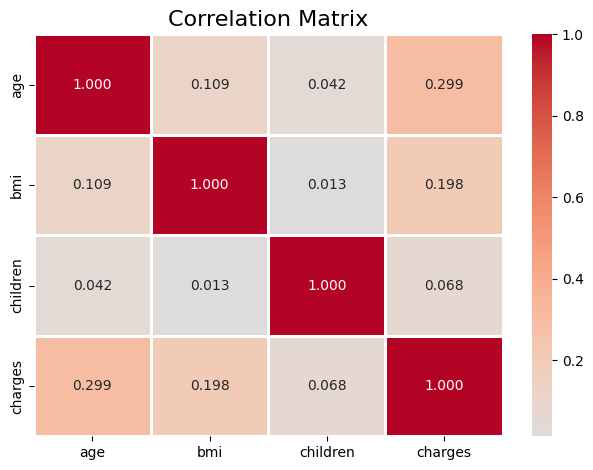

In [14]:
# calculate correlation matrix for numerical features
numerical_features = ['age', 'bmi', 'children', 'charges']
correlation_matrix = df[numerical_features].corr()

# Visualize correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, linewidths=1, fmt='.3f')
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

The correlation matrix shows age (r=0.299) and bmi (r = .0.198) are the strongest linear predictors of charges, while children (r=0.068) has a negligible effect.  
Since correlation does not imply causation, we will now visualize these relationships to uncover patterns not captured by this simple metric.

#### Charges against Age

In [ ]:
# scatter plot of age vs charges, colored by smoker status
fig = px.scatter(df, 
                 x='age', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex', 'bmi'], 
                 title='Charges against Age')
fig.update_traces(marker_size=5)
fig.update_layout(width=700, height=600)
fig.show()

**Analysis**
* Overall positive linear relationship between age and charges for both smokers and non-smokers, consistent with age-related health risks
* Three (potentially 4) distinct charge bands visible across all ages, indicating strong categorical stratification beyond age alone
* Bottom band: Exclusively non-smokers with tight clustering and minimal variance. Likely reflecting healthy non-smokers.
* Middle band: Mixed composition with both smokers and non-smokers
    * Smokers show tighter vertical spread (relatively healthy smokers)
    * Non-smokers show wider vertical spread (high-risk non-smokers with varying conditions hence varying charges)
* Top band: Exclusively smokers with BMI predominantly above 30, representing high-risk obese smokers
* High within-age variance confirms age alone cannot accurately predict charges
* Smoker status creates clear separation, with BMI further stratifying smokers into middle (lower BMI) and upper (obese) bands
* Interaction effects evident: BMI × smoker combination drives extreme charges

#### Charges against BMI

In [12]:
# scatter plot of bmi vs charges, colored by smoker status
fig = px.scatter(df, 
                 x='bmi', 
                 y='charges', 
                 color='smoker', 
                 opacity=0.7, 
                 hover_data=['sex'], 
                 title='Charges against BMI')
fig.update_traces(marker_size=5)
fig.update_layout(width=700, height=600)
fig.show()


# Smoker: BMI vs Charges correlation
smoker_df = df[df['smoker'] == 'yes']
smoker_bmi = smoker_df['bmi']
smoker_charges = smoker_df['charges']
smoker_corr = smoker_bmi.corr(smoker_charges)
print(f"Smoker BMI-Charges correlation: {smoker_corr:.3f}")

# Non-smoker: BMI vs Charges correlation
non_smoker_df = df[df['smoker'] == 'no']
non_smoker_bmi = non_smoker_df['bmi']
non_smoker_charges = non_smoker_df['charges']
non_smoker_corr = non_smoker_bmi.corr(non_smoker_charges)
print(f"Non-Smoker BMI-Charges correlation: {non_smoker_corr:.3f}")

Smoker BMI-Charges correlation: 0.806
Non-Smoker BMI-Charges correlation: 0.084


**Analysis**  
The scatter plot reveals distinct BMI effects by smoking status. Non-smokers (red) show minimal charge variation across BMI levels (r=0.084) with most charges under $15k. Smokers exhibit a strong positive BMI-charge relationship (r=0.806), particularly above BMI 30 where charges escalate to $40k-$60k+. This stark difference in correlation coefficients confirms a significant interaction effect between BMI and smoking status, as BMIs impact on charges is amplified among smokers but negligible among non-smokers. This finding indicates that an interaction term (BMI × smoker) is essential to capture the compounding charges effect, and explains why BMIs overall correlation (r=0.198) severely underestimates its predictive importance.

### Box Plots (Categorical Variables vs Charges)
Examine how charges differ across categorical variables `sex`, `smoker` status, and `region`.

#### Charges by Sex

In [ ]:
# box plot of charges by sex
fig = px.box(df, x='sex', y='charges', title='Charges by Sex')
fig.update_layout(width=500, height=500)
fig.show()

**Analysis**  
Both genders share similar medians ($5k), however males exhibit a modestly higher upper quartile ($19k vs $14k). Both groups display comparable outlier patterns extending to $60k+. Overall, sex appears to be a weak predictor of insurance charges, with the observed modest differences likely attributable to confounding factors such as smoking status (males have higher smoking rate) or BMI rather than sex itself.

### Charges by Smoker

In [69]:
fig = px.box(df, x='smoker', y='charges', title='Charges by Smoker')
fig.update_layout(width=500, height=500)
fig.show()

# levenes test for equal variances 
smoker_charges = df[df['smoker'] == 'yes']['charges']
non_smoker_charges = df[df['smoker'] == 'no']['charges']
stat, p_value = stats.levene(smoker_charges, non_smoker_charges)
print(f"Levene p-value: {p_value}") # results show unequal variances
# welchs t-test 
stat, p_value = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var=False)
print(f"Welchs t-test p-value: {p_value}") 

Levene p-value: 1.5593284881803726e-66
Welchs t-test p-value: 5.88946444671698e-103


**Analysis**  
The box plot reveals stark differences in charge distributions between smokers and non-smokers. Smokers exhibit substantially higher charges across all distributional metrics: median, interquartile range, and maximum values. Non-smokers show minimal variation, while smokers display much wider spread, indicating heterogeneity within the smoking population likely driven by additional risk factors such as BMI. Welch's t-test confirms statistical significance (p < 0.001), with Cohen's d = 2.57 indicating an exceptionally large effect size. Smoking status is the dominant predictor of insurance charges.

### Charges by Region

In [73]:
fig = px.box(df, x='region', y='charges', title='Charges by Region')
fig.update_layout(width=600, height=600)
fig.show()

# ANOVA test for regional differences
regions = [df[df['region'] == r]['charges'] for r in df['region'].unique()]
f_stat, p_value = stats.f_oneway(*regions)

# Calculate eta-squared
# SS_between / SS_total
grand_mean = df['charges'].mean()
ss_between = sum(len(df[df['region'] == r]) * (df[df['region'] == r]['charges'].mean() - grand_mean)**2 
                 for r in df['region'].unique())
ss_total = sum((df['charges'] - grand_mean)**2)
eta_squared = ss_between / ss_total

print(f"ANOVA p-value: {p_value}")
print(f"Eta-squared: {eta_squared}")

ANOVA p-value: 0.0308933560705201
Eta-squared: 0.006634016807031266


**Analysis**  
All four regions exhibit similar charge distributions, with comparable medians, interquartile ranges, and outlier patterns extending to similar maximum values. While the Southeast shows a marginally higher upper quartile, this difference is minimal relative to the overall distributional similarity across regions. This finding suggests that individual health characteristics, rather than geographic pricing, primarily drive insurance costs.

---
## Summary: Feature Understanding for Model Building

### Feature Importance Ranking

**1. Numerical Features (by correlation with charges):**
   1. **age**: r = +0.299 (moderate positive correlation)
   2. **bmi**: r = +0.198 (weak-to-moderate positive correlation)
   3. **children**: r = +0.068 (negligible correlation)

**2. Categorical Features (by effect size):**
   1. **smoker**: Cohen's d = 2.57, p < 0.001 (exceptionally large effect)
   2. **sex**: Small effect, p < 0.05 (statistically significant but weak)
   3. **region**: eta-squared η² = 0.007, p < 0.05 (statistically significant but negligible practical significance)

**3. Key Drivers of Charges  (OVERALL RANKING):**
   1. **smoker** - Dominant predictor, exceptionally large effect size
   2. **age** - Moderate positive correlation, linear relationship
   3. **bmi** - Moderate correlation, stronger impact for smokers (interaction effect)
   4. **children** - Negligible correlation with charges
   5. **sex** - Small but statistically significant effect
   6. **region** - Minimal practical significance

**4. Interaction Term**
   - **BMI × smoker interaction**: BMI effect amplified for smokers (r = 0.806 vs 0.084 for non-smokers)